# 몬테카를로 시뮬레이션(Monte Carlo simulation)

## Monte Carlo simulation 소개

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N=5000; count=0;
x=np.zeros([N, 1]); y=np.zeros([N, 1])
z=np.zeros([N, 1]); r=np.zeros([N, 1])

In [ ]:
x=2*np.random.random((N,1))-1
y=2*np.random.random((N,1))-1
z=np.power(x,2)+np.power(y,2)
r=np.sqrt(z)

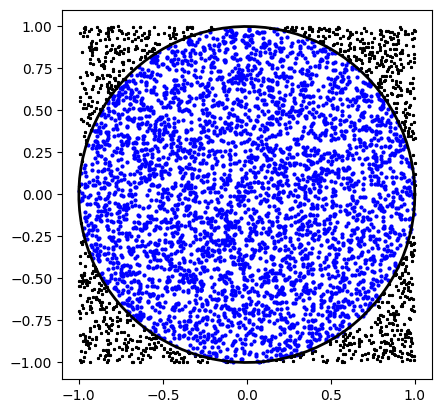

In [ ]:
for i in range(N):
    if r[i]<1:
        count= count+1
        plt.plot(x[i], y[i], 'bo', markersize=2) 
    else:
        plt.plot(x[i], y[i], 'k*', markersize=2) 
t=np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(t), np.sin(t), 'k', linewidth=2)
plt.axis('image'); plt.show()

In [ ]:
Pi=4*count/N
print('Pi=%f'%Pi)

Pi=3.172000


## 주가 경로(stock Process) 생성하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

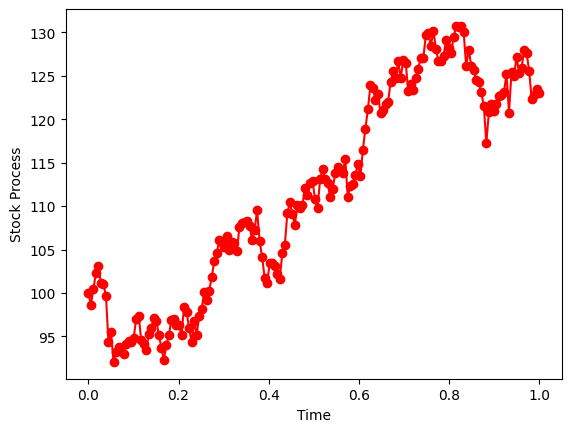

In [ ]:
N=180; S=np.zeros([N,1]); S[0]=100
vol=0.2; r=0.02; T=1; dt=T/N
t=np.linspace(0, T, N)
z=np.random.normal(0, 1, N)

for i in range(N-1):
    S[i+1,0]=S[i,0]*np.exp((r-0.5*vol**2)*dt+vol*z[i]*np.sqrt(dt))
plt.plot(t, S[:,0], 'ro-')
plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.show()

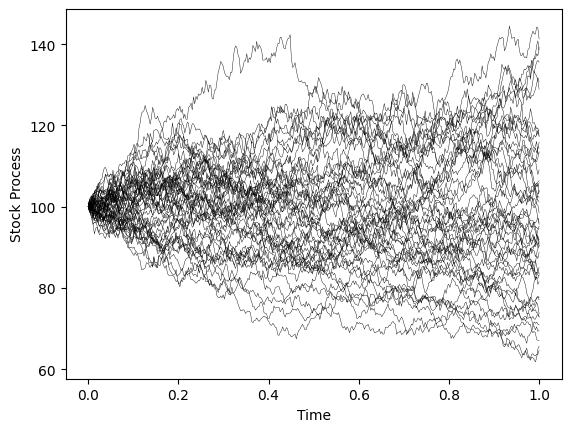

In [ ]:
N=365; S=np.zeros([N,1]); S[0]=100
vol=0.2; r=0.02; T=1; dt=T/N
t=np.linspace(0, T, N)
plt.xlabel('Time')
plt.ylabel('Stock Process')
for k in range(0,50):
    z=np.random.normal(0, 1, N)
    for i in range(N-1):
        S[i+1,0]=S[i,0]*np.exp((r-0.5*vol**2)*dt+vol*z[i]*np.sqrt(dt))
    plt.plot(t[:], S[:], 'k-', linewidth=0.3)
plt.show()

## MC를 이용한 ELS 가격결정

### 기초자산이 1개인 ELS

#### ① KOSPI200 기초자산 ELS

In [ ]:
import numpy as np
from datetime import date

In [ ]:
n=10000    # 시뮬레이션 횟수
r=0.0210    # 이자율, 3년 국고채 금리
vol=0.1778  # 변동성
n0=date.toordinal(date(2018,3,23))  # 최초 기준가격 결정일
n1=date.toordinal(date(2018,9,19))  # 1차 조기 상환일
n2=date.toordinal(date(2019,3,20))  # 2차 조기 상환일
n3=date.toordinal(date(2019,9,19))  # 3차 조기 상환일
n4=date.toordinal(date(2020,3,19))  # 4차 조기 상환일
n5=date.toordinal(date(2020,9,21))  # 5차 조기 상환일
n6=date.toordinal(date(2021,3,19))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.95, 0.95, 0.95, 0.90, 0.90, 0.85])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.022, 0.044, 0.066, 0.088, 0.11, 0.132])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
kib=0.65*S[0]; dummy=0.132  # 낙인 배리어, 더미 이자율

In [ ]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9871.538134971748


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6556, 발생빈도 : 65.56 %
2차 : 1014, 발생빈도 : 10.14 %
3차 : 459, 발생빈도 : 4.59 %
4차 : 388, 발생빈도 : 3.88 %
5차 : 215, 발생빈도 : 2.15 %
6차 : 243, 발생빈도 : 2.43 %
만기상환 발생횟수 : 283, 발생빈도 : 2.83 %
만기손실 발생횟수 : 842, 발생빈도 : 8.42 %


#### 개별주식이 기초자산인 ELS 평가

In [ ]:
import numpy as np
from datetime import date

In [ ]:
n=10000    # 시뮬레이션 횟수
r=0.0325    # 이자율, 3년 국고채 금리
vol=0.4217  # 변동성
n0=date.toordinal(date(2023,5,8))  # 최초 기준가격 결정일
n1=date.toordinal(date(2023,11,8))  # 1차 조기 상환일
n2=date.toordinal(date(2024,5,8))  # 2차 조기 상환일
n3=date.toordinal(date(2024,11,8))  # 3차 조기 상환일
n4=date.toordinal(date(2025,5,8))  # 4차 조기 상환일
n5=date.toordinal(date(2025,11,7))  # 5차 조기 상환일
n6=date.toordinal(date(2026,5,8))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.90, 0.85, 0.80, 0.80, 0.75, 0.75])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.0568, 0.1136, 0.1704, 0.2272, 0.284, 0.3408])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
kib=0.4*S[0]; dummy=0.3408  # 낙인 배리어, 더미 이자율

In [ ]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           St = (S[-3]+S[-2]+S[-1])/3
           payoff[-1]=facevalue*(St/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9656.191074369899


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6076, 발생빈도 : 60.76 %
2차 : 1173, 발생빈도 : 11.73 %
3차 : 550, 발생빈도 : 5.50 %
4차 : 281, 발생빈도 : 2.81 %
5차 : 221, 발생빈도 : 2.21 %
6차 : 151, 발생빈도 : 1.51 %
만기상환 발생횟수 : 215, 발생빈도 : 2.15 %
만기손실 발생횟수 : 1333, 발생빈도 : 13.33 %


### 기초자산이 2개인 ELS

#### 2개의 기초자산이 상관계수를 갖는 주가 경로 생성

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import correlate
plt.close()

In [ ]:
x_vol=0.25; y_vol=0.30
r=0.035
rho=0.3
N=100; T=1
S1=np.zeros((N+1, 1))
S2=np.zeros((N+1, 1))
S1[0]=100; S2[0]=100
dt=T/N; t=np.linspace(0, T, N+1)
correlation=np.array([[1, rho], [rho, 1]])
cholesky=np.linalg.cholesky(correlation)
z0=np.random.normal(0, 1, size=[N, 2])
np.random.seed(56)
z0=np.transpose(z0)
z=np.matmul(cholesky, z0)
Worst_performer=np.zeros((N+1, 1))

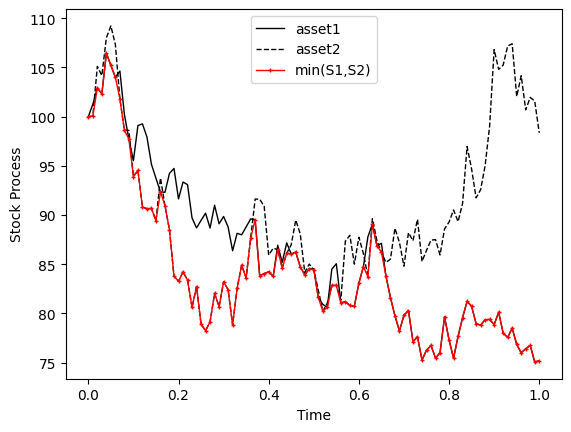

In [ ]:
for i in range(N):
    S1[i+1]=S1[i]*np.exp((r-0.5*x_vol**2)*dt+x_vol*z[0,i]*np.sqrt(dt))
    S2[i+1]=S2[i]*np.exp((r-0.5*y_vol**2)*dt+y_vol*z[1,i]*np.sqrt(dt))
    Worst_performer[i]=min(S1[i,0], S2[i,0])
    Worst_performer[-1]=min(S1[-1,0], S2[-1,0])

plt.plot(t, S1[:], 'k-', label='asset1', linewidth=1, markersize=3.5)
plt.plot(t, S2[:], 'k--', label='asset2', linewidth=1, markersize=3.5)
plt.plot(t, Worst_performer[:], 'r+-', label='min(S1,S2)', linewidth=1, markersize=3.5)
plt.legend()
# plt.xlim(0, 1.0)
# plt.ylim(70, 130)
plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.legend(prop={'size':10})
plt.show()

#### 2개의 기초자산 ELS 가격 계산

#### 지수로 구성하는 경우

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date

In [ ]:
n=10000; r=0.0355  # 시뮬레이션 횟수, 무위험이자율
x_vol=0.2322; y_vol=0.2738  # 두 지수의 연간 변동성
n0=date.toordinal(date(2023, 5, 15))  # 최초 기준가격 결정일
n1=date.toordinal(date(2023, 11, 10))  # 1차 조기 상환일
n2=date.toordinal(date(2024, 5, 9))  # 2차 조기 상환일
n3=date.toordinal(date(2024, 11, 12))  # 3차 조기 상환일
n4=date.toordinal(date(2025, 5, 12))  # 4차 조기 상환일
n5=date.toordinal(date(2025, 11, 11))  # 5차 조기 상환일
n6=date.toordinal(date(2026, 5, 12))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
rho=0.0489; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
coupon_rate=np.array([0.0315, 0.0630, 0.0945, 0.1260, 0.1575, 0.1890])  # 조기 상환시 쿠폰 이자율
oneyear=365; tot_date=n6-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
strike_price=np.array([0.90, 0.90, 0.85, 0.85, 0.80, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
kib=0.5; dummy=0.1890  # 낙인 배리어, 더미 이자율
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  # 
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  # 
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9542.36494500768


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5376, 발생빈도 : 53.76 %
2차 : 1000, 발생빈도 : 10.00 %
3차 : 788, 발생빈도 : 7.88 %
4차 : 334, 발생빈도 : 3.34 %
5차 : 379, 발생빈도 : 3.79 %
6차 : 285, 발생빈도 : 2.85 %
만기상환 발생횟수 : 622, 발생빈도 : 6.22 %
만기손실 발생횟수 : 1216, 발생빈도 : 12.16 %


#### 개별주식으로 구성하는 경우

In [ ]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date

In [ ]:
n=10000; r=0.0355  # 시뮬레이션 횟수, 무위험이자율
x_vol=0.4217; y_vol=0.3509  # 두 지수의 연간 변동성
n0=date.toordinal(date(2023, 5, 12))  # 최초 기준가격 결정일
n1=date.toordinal(date(2023, 11, 10))  # 1차 조기 상환일
n2=date.toordinal(date(2024, 5, 10))  # 2차 조기 상환일
n3=date.toordinal(date(2024, 11, 12))  # 3차 조기 상환일
n4=date.toordinal(date(2025, 5, 12))  # 4차 조기 상환일
n5=date.toordinal(date(2025, 11, 12))  # 5차 조기 상환일
n6=date.toordinal(date(2026, 5, 12))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
rho=0.29555; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
coupon_rate=np.array([0.07, 0.14, 0.21, 0.28, 0.35, 0.42])  # 조기 상환시 쿠폰 이자율
oneyear=365; tot_date=n6-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
strike_price=np.array([0.90, 0.90, 0.85, 0.85, 0.80, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
kib=0.4; dummy=0.42  # 낙인 배리어, 더미 이자율
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  # 
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  # 
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           WPL=(WP[-1]+WP[-2]+WP[-3])/3
           payoff[-1]=facevalue*WPL
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9297.229315184095


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 4294, 발생빈도 : 42.94 %
2차 : 1019, 발생빈도 : 10.19 %
3차 : 682, 발생빈도 : 6.82 %
4차 : 357, 발생빈도 : 3.57 %
5차 : 352, 발생빈도 : 3.52 %
6차 : 295, 발생빈도 : 2.95 %
만기상환 발생횟수 : 694, 발생빈도 : 6.94 %
만기손실 발생횟수 : 2307, 발생빈도 : 23.07 %


### 기초자산이 3개인 ELS

#### 3개의 기초자산이 상관계수를 갖는 주가 경로 생성

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import correlate

In [2]:
x_vol=0.2662; y_vol=0.2105; z_vol=0.2111
r=0.0165
rho_xy=0.279; rho_xz=0.2895; rho_yz=0.5256
N=80; T=1; dt=T/N
S1=np.zeros((N+1, 1))
S2=np.zeros((N+1, 1))
S3=np.zeros((N+1, 1))
S1[0]=100; S2[0]=100; S3[0]=100
t=np.linspace(0, T, N+1)
correlation=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
cholesky=np.linalg.cholesky(correlation)
z0=np.random.normal(0, 1, size=[N, 3])
np.random.seed(42)
z0=np.transpose(z0)
z=np.matmul(cholesky, z0)
Worst_performer=np.zeros((N+1, 1))

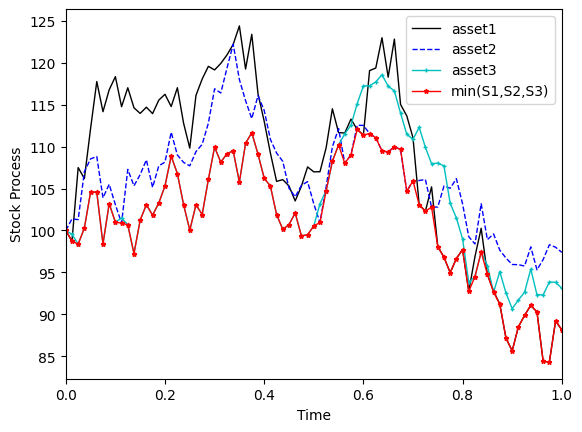

In [3]:
plt.xlim(0, 1)
# plt.ylim(60, 170)

for i in range(N):
    S1[i+1]=S1[i]*np.exp((r-0.5*x_vol**2)*dt+x_vol*z[0,i]*np.sqrt(dt))
    S2[i+1]=S2[i]*np.exp((r-0.5*y_vol**2)*dt+y_vol*z[1,i]*np.sqrt(dt))
    S3[i+1]=S3[i]*np.exp((r-0.5*z_vol**2)*dt+z_vol*z[2,i]*np.sqrt(dt))
    Worst_performer[i]=min(S1[i,0], S2[i,0], S3[i,0])
    Worst_performer[-1]=min(S1[-1,0], S2[-1,0], S2[-1,0])

plt.plot(t, S1[:], 'k-', label='asset1', linewidth=1, markersize=3.5)
plt.plot(t, S2[:], 'b--', label='asset2', linewidth=1, markersize=3.5)
plt.plot(t, S3[:], 'c+-', label='asset3', linewidth=1, markersize=3.5)
plt.plot(t, Worst_performer[:], 'r*-', label='min(S1,S2,S3)', linewidth=1, markersize=3.5)

plt.xlabel('Time')
plt.ylabel('Stock Process')
plt.legend(prop={'size':10})
plt.show()

#### 3개의 기초자산 ELS 가격 계산

In [4]:
import numpy as np
from numpy.ma.core import correlate
from datetime import date

In [8]:
n=10000; r=0.0165
x_vol=0.2662; y_vol=0.2105; z_vol=0.2111
n0=date.toordinal(date(2023, 5, 15))  # 최초 기준가격 결정일
n1=date.toordinal(date(2023, 11, 10))  # 1차 조기 상환일
n2=date.toordinal(date(2024, 5, 9))  # 2차 조기 상환일
n3=date.toordinal(date(2024 , 11, 12))  # 3차 조기 상환일
n4=date.toordinal(date(2025, 5, 12))  # 4차 조기 상환일
n5=date.toordinal(date(2025, 11, 11))  # 5차 조기 상환일
n6=date.toordinal(date(2026, 5, 12))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
rho_xy=0.278; rho_xz=0.2896; rho_yz=0.5256  # 상관계수
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.95, 0.95, 0.90, 0.90, 0.85, 0.85])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.048, 0.096, 0.144, 0.192, 0.124, 0.288])  # 조기 상환시 쿠폰 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
kib=0.50; dummy=0.06  # 낙인 배리어, 더미 이자율
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [9]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  # 
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  # 
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]
    
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9754.10301576625


In [10]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 4190, 발생빈도 : 41.90 %
2차 : 1040, 발생빈도 : 10.40 %
3차 : 865, 발생빈도 : 8.65 %
4차 : 402, 발생빈도 : 4.02 %
5차 : 423, 발생빈도 : 4.23 %
6차 : 267, 발생빈도 : 2.67 %
만기상환 발생횟수 : 1391, 발생빈도 : 13.91 %
만기손실 발생횟수 : 1422, 발생빈도 : 14.22 %
